In [ ]:
        # If "Infeasible", remove some constraints & re-solve
        remove_list = []
        if solver_status == "Infeasible":
            for c_name, c_expr in prob.constraints.items():
                print(f"  {c_name}: {c_expr}")
                if "UpperTraj" in c_name or "LowerTraj" in c_name or "VolumeConstraint_Leaves" in c_name:
                    remove_list.append(c_name)
                    
            for c_name in remove_list:
                print(f"[Bucket {b}] Removing {c_name} and re-solving.")
                del prob.constraints[c_name]
                    
            # Re-solve
            prob.solve()
            solver_status = LpStatus[prob.status]

In [110]:
import random, copy
from pulp import (
    LpProblem, LpMinimize,
    LpVariable, LpContinuous,
    lpSum, LpStatus, value
)

def receding_horizon_trading_with_epsilon_exploration(
    B,
    Q,
    L, U,
    fill_rates,        # dict: fill_rates[b]['A','N','P']
    alpha_update,      # weighting for fill-rate updates
    market_executed,   # dict: total market volume up to bucket b
    max_participation, # fraction in (0,1)
    exploration_schedule=None,  # function(b)-> epsilon in [0,1]
    verbose=True
):
    """
    Multi-Stage (Receding Horizon) integer-only order slicing for 3 agents (A,N,P), with:
      1) EXACT fill = Q in the model (no overfill in predicted sense)
      2) Volume constraints
      3) Fill rate updates from actual fills (exponential smoothing)
      4) Cost minimization (cost_A=2, cost_N=1, cost_P=0)
      5) Epsilon-exploration logic after the solver solution

    B: number of buckets
    Q: total shares to fill EXACTLY in the model
    L, U: arrays (1..B) for cumulative trajectory fraction: L[b], U[b]
    fill_rates: predicted fill fraction, e.g. fill_rates[b]['A'] in [0,1]
    alpha_update: how much weight to give newly observed fill fraction
    market_executed: total market volume up to each bucket
    max_participation: fraction of leftover market volume
    exploration_schedule: function(b)-> float in [0,1], the fraction of randomization for bucket b
    verbose: if True, print logs

    Returns:
      A dictionary with:
        - 'allocations': integer shares posted each bucket & agent (after exploration)
        - 'predicted_fills': solver's predicted fill
        - 'realized_fills': actual fill from simulation/market
        - 'cumulative_realized': running sum of actual fills
        - 'final_status': solver status
    """

    # -- Data structures for results --
    xAlloc = {b: {'A':0, 'N':0, 'P':0} for b in range(1,B+1)}   # final posted allocations (after exploration)
    predicted_fills = {b: {'A':0.0,'N':0.0,'P':0.0} for b in range(1,B+1)}
    realized_fills  = {b: {'A':0.0,'N':0.0,'P':0.0} for b in range(1,B+1)}

    # If no exploration schedule is given, define a default
    if exploration_schedule is None:
        def exploration_schedule(bkt):
            # e.g. starts at 20% for bucket 1, decays by 5% each bucket
            # until it hits 0
            return 0.0
            return max(0.0, 0.2 - 0.05*(bkt-1))

    # Keep track of "predicted fill so far" from model's perspective
    cumulative_pred_so_far = 0.0

    # Keep track of "actual fill so far"
    cumulative_realized = 0.0

    # Helper for trajectory bounds in actual shares
    def target_trajectory(bkt):
        return 0.5*(U[bkt]*Q + L[bkt]*Q)
    def lower_bound(bkt):
        return L[bkt]*Q
    def upper_bound(bkt):
        return U[bkt]*Q

    # ============ MAIN LOOP: Bucket b = 1..B ============
    for b in range(1, B+1):

        # --------------------------------------------
        # 1) Build IP from bucket b..B
        # --------------------------------------------
        prob = LpProblem(f"MPC_{b}", LpMinimize)

        # Decision variables (integer)
        xA = {}
        xN = {}
        xP = {}
        for k in range(b, B+1):
            xA[k] = LpVariable(f"xA_{k}", lowBound=0, cat=LpContinuous)
            xN[k] = LpVariable(f"xN_{k}", lowBound=0, cat=LpContinuous)
            xP[k] = LpVariable(f"xP_{k}", lowBound=0, cat=LpContinuous)

        # --------------------------------------------
        # 2) Objective: cost = sum_{k=b..B} [2*xA_k + xN_k]
        # --------------------------------------------
        cost_expr = lpSum([3*xA[k] + xN[k] for k in range(b, B+1)])
        prob += cost_expr, "Minimize_Cost"

        # --------------------------------------------
        # 3) EXACT final fill constraint: predicted_fills == Q by bucket B
        # --------------------------------------------
        fill_expr = cumulative_realized
        for k in range(b, B+1):
            fill_expr += (xA[k]*fill_rates[k]['A']
                         +xN[k]*fill_rates[k]['N']
                         +xP[k]*fill_rates[k]['P'])
        exact_fill_name = "Exact_Fill"
        prob += (fill_expr == Q), exact_fill_name

        # --------------------------------------------
        # 4) Trajectory constraints
        #    for k in [b..B]: L[k]*Q <= (cumulative_pred_so_far + sum_{j=b..k} fill_j ) <= U[k]*Q
        # --------------------------------------------
        for k in range(b, B+1):
            fill_expr_k = cumulative_realized
            for j in range(b, k+1):
                fill_expr_k += (
                    xA[j]*fill_rates[j]['A'] +
                    xN[j]*fill_rates[j]['N'] +
                    xP[j]*fill_rates[j]['P']
                )
            prob += (fill_expr_k >= lower_bound(k)), f"LowerTraj_{k}"
            prob += (fill_expr_k <= upper_bound(k)), f"UpperTraj_{k}"

        # --------------------------------------------
        # 5) Volume constraint
        # --------------------------------------------
        for k in range(b, B+1):
            total_post_k = xA[k] + xN[k] + xP[k]
            fills_up_to_k_minus_1 = cumulative_realized
            for j in range(b, k):
                fills_up_to_k_minus_1 += (
                    xA[j]*fill_rates[j]['A'] +
                    xN[j]*fill_rates[j]['N'] +
                    xP[j]*fill_rates[j]['P']
                )
            leftover_market = market_executed[k] - fills_up_to_k_minus_1
            prob += (total_post_k <= max_participation*leftover_market), f"VolumeConstraint_part_{k}"
            prob += (total_post_k <= Q-cumulative_realized), f"VolumeConstraint_Leaves_{k}"

        # --------------------------------------------
        # 6) Solve the IP
        # --------------------------------------------
        prob.solve()
        solver_status = LpStatus[prob.status]
        if verbose:
            print(f"\n[Bucket {b}] Solve status: {solver_status}")
            
        if solver_status != "Optimal":
            if verbose:
                print(f"[Bucket {b}] No Optimal solution found. Exiting.")
            return {
                'allocations': xAlloc,
                'predicted_fills': predicted_fills,
                'realized_fills': realized_fills,
                'cumulative_realized': {},
                'final_status': solver_status
            }

        # --------------------------------------------
        # 7) Extract solution for the current bucket b
        # --------------------------------------------
        xA_star = int(value(xA[b]))
        xN_star = int(value(xN[b]))
        xP_star = int(value(xP[b]))

        if verbose:
            print(f"[Bucket {b}] IP solution => A={xA_star}, N={xN_star}, P={xP_star}")

        # --------------------------------------------
        # 8) Epsilon-Exploration
        #    We'll replace some fraction epsilon_b of the solver's solution
        #    with a random distribution among A/N/P, then re-round to int.
        # --------------------------------------------
        eps_b = exploration_schedule(b)
        total_opt = xA_star + xN_star + xP_star

        # Only do exploration if total_opt > 0 and eps_b > 0
        if total_opt > 0 and eps_b > 1e-9:
            # 8a) The portion we keep from solver's solution
            keepA = round((1.0 - eps_b) * xA_star)
            keepN = round((1.0 - eps_b) * xN_star)
            keepP = round((1.0 - eps_b) * xP_star)

            leftover_shares = total_opt - ((keepA + keepN + keepP))
            # leftover_shares might be negative or positive due to rounding. 
            # We'll adjust it properly below.

            # 8b) Distribute leftover_shares randomly among A/N/P
            if leftover_shares > 0:
                rA, rN, rP = random.random(), random.random(), random.random()
                r_sum = rA + rN + rP
                fracA = rA / r_sum
                fracN = rN / r_sum
                fracP = rP / r_sum

                distA = int(round(fracA * leftover_shares))
                distN = int(round(fracN * leftover_shares))
                # assign the remainder to P to ensure total is leftover_shares
                distP = leftover_shares - distA - distN
            else:
                # If leftover_shares <= 0, we do no random distribution
                distA, distN, distP = 0,0,0

            xA_post = keepA + distA
            xN_post = keepN + distN
            xP_post = keepP + distP

        else:
            # No exploration
            xA_post = xA_star
            xN_post = xN_star
            xP_post = xP_star

        # This is the final posted allocation for the real market
        xAlloc[b]['A'] = xA_post
        xAlloc[b]['N'] = xN_post
        xAlloc[b]['P'] = xP_post

        if verbose:
            print(f"[Bucket {b}] After exploration => A={xA_post}, N={xN_post}, P={xP_post}, eps={eps_b:.2f}")

        # --------------------------------------------
        # 9) Simulate/Observe actual fills
        #    We'll add random noise around fill_rates[b].
        # --------------------------------------------
        actual_frac_A = max(0.0, min(1.0, fill_rates[b]['A'] + 0.1*(random.random()-0.05)))
        actual_frac_N = max(0.0, min(1.0, fill_rates[b]['N'] + 0.1*(random.random()-0.5)))
        actual_frac_P = max(0.0, min(1.0, fill_rates[b]['P'] + 0.1*(random.random()-0.75)))

        fillA = xA_post * actual_frac_A
        fillN = xN_post * actual_frac_N
        fillP = xP_post * actual_frac_P

        realized_fills[b]['A'] = fillA
        realized_fills[b]['N'] = fillN
        realized_fills[b]['P'] = fillP
        cumulative_realized += (fillA + fillN + fillP)

        if verbose:
            print(f"[Bucket {b}] Actual fill fractions => A={actual_frac_A:.2f}, N={actual_frac_N:.2f}, P={actual_frac_P:.2f}")
            print(f"[Bucket {b}] Realized fills => A={fillA:.1f}, N={fillN:.1f}, P={fillP:.1f}.  Cumulative={cumulative_realized:.1f}")

        # --------------------------------------------
        # 10) Update fill rates for bucket b+1 using actual fill fraction
        # --------------------------------------------
        if b < B-1:
            for agent in ['A','N','P']:
                old_rate = fill_rates[b+1][agent]
                posted   = xAlloc[b][agent]
                if posted > 0:
                    realized_frac = realized_fills[b][agent] / posted
                else:
                    realized_frac = old_rate  # no new info if posted=0

                new_rate = alpha_update*realized_frac + (1-alpha_update)*old_rate
                new_rate = max(0.0, min(1.0, new_rate))
                fill_rates[b+1][agent] = new_rate

            if verbose:
                print(f"[Bucket {b}] Updated fill_rates for bucket {b+1}: {fill_rates[b+1]}")

        # --------------------------------------------
        # 11) Update the model's "predicted fill so far"
        #     using the solver's allocation (xA_star, etc.)
        #     and the solver's predicted fraction (fill_rates[b]).
        # --------------------------------------------
        # We maintain the EXACT fill constraint from the solver's perspective.
        # That is, we do NOT use xA_post or the random fraction for the model's sum,
        # because that might break the solver's exact Q. 
        predictedA = xA_star * fill_rates[b]['A']
        predictedN = xN_star * fill_rates[b]['N']
        predictedP = xP_star * fill_rates[b]['P']

        predicted_fills[b]['A'] = predictedA
        predicted_fills[b]['N'] = predictedN
        predicted_fills[b]['P'] = predictedP
        cumulative_pred_so_far += (predictedA + predictedN + predictedP)

    # end for b in 1..B

    # Summarize final status
    final_status = "Completed"

    return {
        'allocations': xAlloc,  # final posted allocations
        'predicted_fills': predicted_fills,
        'realized_fills': realized_fills,
        'cumulative_realized': {
            b: sum(realized_fills[k]['A']+realized_fills[k]['N']+realized_fills[k]['P'] for k in range(1,b+1))
            for b in range(1,B+1)
        },
        'final_status': final_status
    }


# -------------------------------------
# Example usage / demonstration
# -------------------------------------
if __name__ == "__main__":
    # Example parameters
    B = 5
    Q = 10000
    alpha_update = 0.5
    max_participation = 0.1

    # Trajectory constraints (1-indexed):
    #   b=1 => 0..20%
    #   b=2 => 10..40%
    #   b=3 => 30..60%
    #   b=4 => 50..80%
    #   b=5 => 100..100% (must complete exactly in the model)
    L = [0, 0.0, 0.1, 0.3, 0.5, 1.0]
    U = [0, 0.2, 0.4, 0.7, 0.9, 1.0]

    # Initial fill rates
    fill_rates = {
        1: {'A':0.99, 'N':0.5,  'P':0.25},
        2: {'A':0.99, 'N':0.50, 'P':0.25},
        3: {'A':0.99, 'N':0.48, 'P':0.25},
        4: {'A':0.99, 'N':0.50, 'P':0.25},
        5: {'A':1.00, 'N':0.50, 'P':0.25},
    }

    # Market volume up to each bucket
    market_executed = {
        1: 20000,
        2: 40000,
        3: 60000,
        4: 90000,
        5: 120000
    }

    # Example custom exploration schedule 
    # (start at 20%, reduce by 5% each bucket, floor at 0%)
    def exploration_schedule(b):
        return max(0.0, 0.20 - 0.05*(b-1))

    # Run the receding-horizon with epsilon exploration
    results = receding_horizon_trading_with_epsilon_exploration(
        B=B,
        Q=Q,
        L=L,
        U=U,
        fill_rates=fill_rates,
        alpha_update=alpha_update,
        market_executed=market_executed,
        max_participation=max_participation,
        exploration_schedule=exploration_schedule,
        verbose=True
    )
    
    alloc_p = [0.0]
    alloc_b = 0.0
    fill_p = [0.0]
    print("\n===== FINAL RESULTS =====")
    print("Allocations (after exploration) per bucket:")
    for b in range(1, B+1):
        print(f"  Bucket {b}: {results['allocations'][b]}")
        alloc_b = (results['allocations'][b]['A'] + results['allocations'][b]['N'] + results['allocations'][b]['P'])
        if b > 1:
            alloc_b += results['cumulative_realized'][b-1]
        alloc_p.append(alloc_b / Q)

    #print("\nSolver's Predicted Fills per bucket (model-based):")
    #for b in range(1, B+1):
    #    print(f"  Bucket {b}: {results['predicted_fills'][b]}")

    print("\nRealized Fills (actual, with noise):")
    for b in range(1, B+1):
        print(f"  Bucket {b}: {results['realized_fills'][b]}")

    print("\nCumulative Realized Fill after each bucket:")
    for b in range(1, B+1):
        print(f"  Bucket {b}: {results['cumulative_realized'][b]:.1f}")
        fill_p.append(results['cumulative_realized'][b] / Q)

    print("\nFinal Status:", results['final_status'])
    print(f"\n{alloc_p}")
    print(f"\n{fill_p}")
    



[Bucket 1] Solve status: Optimal
[Bucket 1] IP solution => A=0, N=0, P=2000
[Bucket 1] After exploration => A=54, N=248, P=1698, eps=0.20
[Bucket 1] Actual fill fractions => A=1.00, N=0.51, P=0.26
[Bucket 1] Realized fills => A=54.0, N=126.8, P=449.0.  Cumulative=629.8
[Bucket 1] Updated fill_rates for bucket 2: {'A': 0.995, 'N': 0.5055785941491838, 'P': 0.25721363127718894}

[Bucket 2] Solve status: Optimal
[Bucket 2] IP solution => A=0, N=0, P=3937
[Bucket 2] After exploration => A=226, N=223, P=3488, eps=0.15
[Bucket 2] Actual fill fractions => A=1.00, N=0.50, P=0.21
[Bucket 2] Realized fills => A=226.0, N=112.3, P=732.1.  Cumulative=1700.2
[Bucket 2] Updated fill_rates for bucket 3: {'A': 0.995, 'N': 0.49174009283782627, 'P': 0.22994848669470097}

[Bucket 3] Solve status: Optimal
[Bucket 3] IP solution => A=2549, N=3280, P=0
[Bucket 3] After exploration => A=2581, N=2965, P=283, eps=0.10
[Bucket 3] Actual fill fractions => A=1.00, N=0.50, P=0.23
[Bucket 3] Realized fills => A=2570

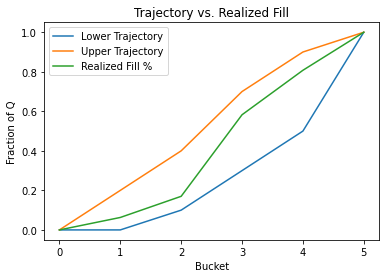

In [111]:
import matplotlib.pyplot as plt

# Create a single chart showing all four lines
buckets = [0, 1, 2, 3, 4, 5]
plt.plot(buckets, L, label='Lower Trajectory')
plt.plot(buckets, U, label='Upper Trajectory')
#plt.plot(buckets, alloc_p, label='Cumulative Allocation %')
plt.plot(buckets, fill_p, label='Realized Fill %')

plt.xlabel('Bucket')
plt.ylabel('Fraction of Q')
plt.title('Trajectory vs. Realized Fill')
plt.legend()

plt.show()

In [ ]:
    market_executed = {
        1: 20000,
        2: 40000,
        3: 60000,
        4: 90000,
        5: 120000
    }

In [62]:
print (random.random())

0.20421266476553623
